# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from pymystem3 import Mystem
import re
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve


In [2]:
comments = pd.read_csv('/datasets/toxic_comments.csv')
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [3]:
comments.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
display(comments['toxic'].value_counts())
class_ratio = comments['toxic'].value_counts()[0] / comments['toxic'].value_counts()[1]
class_ratio

0    143346
1     16225
Name: toxic, dtype: int64

8.834884437596301

Мы видим, что классы не сбалансированы, соотношение почти 1:9. Опробуем 2 способа балансировки и выберем лучший:
- изменим веса классов при обучении модели;
- ресемплируем с уменьшением класса "0".

Подготовим признаки.

In [5]:
%%time

m = Mystem()

def lemmatize_text(text):
    text = text.lower()
    lemm_text = "".join(m.lemmatize(text))
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text) 
    return " ".join(cleared_text.split())

comments['lemm_text'] = comments['text'].apply(lemmatize_text)

comments = comments.drop(['text'], axis=1)
del m

CPU times: user 33.2 s, sys: 7.48 s, total: 40.7 s
Wall time: 1min 28s


Разобьем выборку по отношению 3:1:1.

In [6]:
target = comments['toxic']
features = comments.drop(['toxic'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size = 0.4, 
                                                                              random_state = 12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            test_size = 0.5,
                                                                            random_state = 12345)

nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

features_train = count_tf_idf.fit_transform(features_train['lemm_text'].values)
features_valid = count_tf_idf.transform(features_valid['lemm_text'].values)
features_test = count_tf_idf.transform(features_test['lemm_text'].values)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(95742, 126482)
(31914, 126482)
(31915, 126482)


Из-за размеров выборки уменьшим количество кроссвалидаций до 3-х.

In [8]:
cv_counts = 3

In [9]:
%%time

classificator = LogisticRegression()
train_f1 = cross_val_score(classificator, 
                      features_train, 
                      target_train, 
                      cv=cv_counts, 
                      scoring='f1').mean()
print('F1 на CV', train_f1)

F1 на CV 0.6732751694870752
CPU times: user 44.1 s, sys: 1min 1s, total: 1min 45s
Wall time: 1min 46s


### Работа с балансом классов

#### Изменение весов классов

In [10]:
%%time

dict_classes={0:1, 1:class_ratio}
classificator = LogisticRegression(class_weight=dict_classes)
train_f1_ballanced = cross_val_score(classificator, 
                                    features_train, 
                                    target_train, 
                                    cv=cv_counts, 
                                    scoring='f1').mean()
print('F1 на CV с балансированными классами', train_f1_ballanced)

F1 на CV с балансированными классами 0.751508005539078
CPU times: user 51.4 s, sys: 1min 7s, total: 1min 58s
Wall time: 1min 59s


In [11]:
%%time

classificator = LogisticRegression(class_weight='balanced')
train_f1_balanced = cross_val_score(classificator, 
                                    features_train, 
                                    target_train, 
                                    cv=cv_counts, 
                                    scoring='f1').mean()
print('F1 на CV с балансированными классами', train_f1_ballanced)

F1 на CV с балансированными классами 0.751508005539078
CPU times: user 28.8 s, sys: 37.2 s, total: 1min 6s
Wall time: 1min 6s


Видим, что F1-мера увеличилась, а судя по скорости работы, то быстрее работает встроенные метод баланса классов.

#### Ресемплирование с уменьшением класса "0"

In [12]:
comments_train = comments.iloc[target_train.index]

target_train_class_zero = comments_train[comments_train['toxic'] == 0]['toxic']
target_train_class_one = comments_train[comments_train['toxic'] == 1]['toxic']

In [13]:
target_train_class_zero_downsample = target_train_class_zero.sample(target_train_class_one.shape[0],
                                                                    random_state = 12345)
target_train_downsample = pd.concat([target_train_class_zero_downsample, target_train_class_one])

features_train_downsample = comments.iloc[target_train_downsample.index]
features_train_downsample, target_train_downsample = shuffle(features_train_downsample,
                                                             target_train_downsample,
                                                             random_state = 12345)

features_train_downsample = count_tf_idf.transform(features_train_downsample['lemm_text']
                                                   .values.astype('U'))
del count_tf_idf
del stopwords

In [14]:
%%time

classificator = LogisticRegression()
train_f1_downsampled = cross_val_score(classificator,
                      features_train_downsample, 
                      target_train_downsample, 
                      cv=cv_counts, 
                      scoring='f1').mean()
print('F1 на CV с уменьшением классов', train_f1_downsampled)

F1 на CV с уменьшением классов 0.8792825300830076
CPU times: user 13.3 s, sys: 18.4 s, total: 31.7 s
Wall time: 31.7 s


Построим ROC-AUC графики и просмотрим таблицу результатов баллансирования.

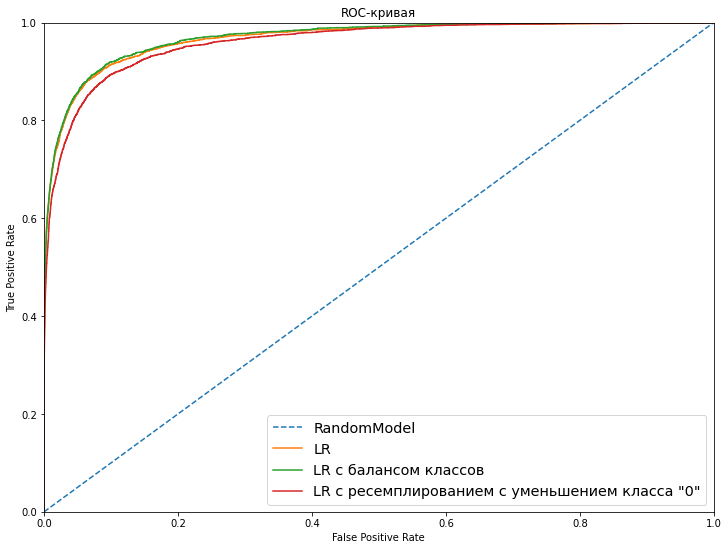

In [15]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


classificator = LogisticRegression()
classificator.fit(features_train, target_train)
probabilities_valid = classificator.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1 = f1_score(target_valid, classificator.predict(features_valid))
plt.plot(fpr, tpr, label='LR')

classificator = LogisticRegression(class_weight=dict_classes)
classificator.fit(features_train, target_train)
probabilities_valid = classificator.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_balanced = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1_balanced = f1_score(target_valid, classificator.predict(features_valid))
plt.plot(fpr, tpr, label='LR с балансом классов')

classificator = LogisticRegression()
classificator.fit(features_train_downsample,target_train_downsample)
probabilities_valid = classificator.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_downsampled = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1_downsampled = f1_score(target_valid, classificator.predict(features_valid))
plt.plot(fpr, tpr, label='LR с ресемплированием с уменьшением класса "0"')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

In [16]:
index = ['LogisticRegression',
         'LR (баланс классов)',
         'LR (ресемплинг с уменьшением класса "0")']
data = {'F1 на CV':[train_f1,
                    train_f1_balanced,
                    train_f1_downsampled],
        'F1 на валидации':[valid_f1,
                           valid_f1_balanced,
                           valid_f1_downsampled],
        'AUC-ROC':[auc_roc,
                   auc_roc_balanced,
                   auc_roc_downsampled]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data

,F1 на CV,F1 на валидации,AUC-ROC
LogisticRegression,0.673275,0.727239,0.967538
LR (баланс классов),0.744431,0.763463,0.969309
"LR (ресемплинг с уменьшением класса ""0"")",0.879283,0.695566,0.960055


Остановимся на балансировке классов по весу.

### Вывод

В ходе преподготовки были получены признаки для обучения и разделена выборка на обучающую, валидационную и тестовую.

На тестировании оптимальными показателями F1 и AUC-ROC обладает классификатор, где учтен вес классов. В обучении мы будем использовать именно этот метод балансирования.

## Обучение

Обучим следующие модели:

- LogisticRegression;
- DecisionTreeClassifier;
- SGDClassifier.

### LogisticRegression

In [17]:
%%time

classificator = LogisticRegression()
hyperparams = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'C':[0.1, 1, 10],
                'class_weight':[dict_classes]}]


clf = GridSearchCV(classificator, hyperparams, scoring = 'f1',cv = cv_counts)
clf.fit(features_train, target_train)
print("Лучшие параметры:")
print()
LR_best_params = clf.best_params_
print(LR_best_params)
print()
print("Метрика качества при различных параметрах:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_LR = max(means)

Лучшие параметры:

{'C': 10, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'newton-cg'}

Метрика качества при различных параметрах:

0.714455 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'newton-cg'}
0.714545 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'lbfgs'}
0.714455 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'liblinear'}
0.751426 for {'C': 1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'newton-cg'}
0.751508 for {'C': 1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'lbfgs'}
0.751258 for {'C': 1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'liblinear'}
0.764921 for {'C': 10, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'newton-cg'}
0.763937 for {'C': 10, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'lbfgs'}
0.764859 for {'C': 10, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'liblinear'}

CPU times: user 4min 29s, sys: 5min 30s,

In [18]:
%%time

classificator = LogisticRegression()
classificator.set_params(**LR_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_LR = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_LR)
print('F1 на валидации', valid_f1_LR)

F1 на cv 0.764921323455282
F1 на валидации 0.7676588183029764
CPU times: user 18 s, sys: 20.5 s, total: 38.6 s
Wall time: 38.6 s


### DecisionTreeClassifier

In [19]:
%%time

classificator = DecisionTreeClassifier()
hyperparams = [{'max_depth':[x for x in range(30,51,2)],
                'random_state':[12345],
                'class_weight':[dict_classes]}]


clf = GridSearchCV(classificator, hyperparams, scoring = 'f1', cv = cv_counts)
clf.fit(features_train, target_train)
print("Лучшие параметры:")
print()
DTC_best_params = clf.best_params_
print(DTC_best_params)
print()
print("Метрика качества при различных параметрах:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_DTC = max(means)

Лучшие параметры:

{'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 48, 'random_state': 12345}

Метрика качества при различных параметрах:

0.616734 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 30, 'random_state': 12345}
0.612000 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 32, 'random_state': 12345}
0.617521 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 34, 'random_state': 12345}
0.620997 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 36, 'random_state': 12345}
0.618405 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 38, 'random_state': 12345}
0.608841 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 40, 'random_state': 12345}
0.610390 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 42, 'random_state': 12345}
0.613964 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 44, 'random_state': 12345}
0.617732 for {'class_weight': {0: 1, 1: 8.8348844

In [20]:
%%time

classificator = DecisionTreeClassifier()
classificator.set_params(**DTC_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_DTC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_DTC)
print('F1 на валидации', valid_f1_DTC)

F1 на cv 0.6222372417342141
F1 на валидации 0.6096675860066773
CPU times: user 28.5 s, sys: 378 ms, total: 28.9 s
Wall time: 28.9 s


### SGDClassifier

In [21]:
%%time

classificator = SGDClassifier()
hyperparams = [{'loss':['hinge', 'log', 'modified_huber'],
                'learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'],
                'eta0':[0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
                'random_state':[12345],
                'class_weight':[dict_classes]}]


clf = GridSearchCV(classificator, hyperparams, scoring = 'f1', cv = cv_counts)
clf.fit(features_train, target_train)
print("Лучшие параметры:")
print()
SGDC_best_params = clf.best_params_
print(SGDC_best_params)
print()
print("Метрика качества при различных параметрах:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_SGDC = max(means)

Лучшие параметры:

{'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.5, 'learning_rate': 'adaptive', 'loss': 'modified_huber', 'random_state': 12345}

Метрика качества при различных параметрах:

0.738449 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'hinge', 'random_state': 12345}
0.717600 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'log', 'random_state': 12345}
0.752431 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'modified_huber', 'random_state': 12345}
0.737587 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'hinge', 'random_state': 12345}
0.720393 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'log', 'random_state': 12345}
0.748816 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learn

In [22]:
%%time

classificator = SGDClassifier()
classificator.set_params(**SGDC_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_SGDC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_SGDC)
print('F1 на валидации', valid_f1_SGDC)

F1 на cv 0.7587496819928928
F1 на валидации 0.7636516381965837
CPU times: user 1.55 s, sys: 92.2 ms, total: 1.64 s
Wall time: 1.65 s


### Итог

In [23]:
index = ['LogisticRegression',
         'DecisionTreeClassifier',
         'SGDClassifier']
data = {'F1 на CV':[cv_f1_LR,
                    cv_f1_DTC,
                    cv_f1_SGDC],
        'F1 на валидации':[valid_f1_LR,
                           valid_f1_DTC,
                           valid_f1_SGDC]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Выполнение задачи'] = scores_data['F1 на валидации'] > 0.75
scores_data

,F1 на CV,F1 на валидации,Выполнение задачи
LogisticRegression,0.764921,0.767659,True
DecisionTreeClassifier,0.622237,0.609668,False
SGDClassifier,0.758750,0.763652,True


### Вывод

Из обученных моделей рубеж F1-метрики в 0,75 прошли LogisticRegression и SGDClassifier.

## Выводы

Проведем получение F1-меры, precision, recall, accuracy и roc_auc. Так же построим графики.

Метрики LogisticRegression
ROC AUC: 0.9644859975874468
F1: 0.7646619907476495
Precision: 0.733887138355772
Recall: 0.7981308411214953
Accuracy: 0.9505874980416732

Метрики SGDClassifier
ROC AUC: 0.969185603254939
F1: 0.7575928008998876
Precision: 0.690415171706817
Recall: 0.8392523364485981
Accuracy: 0.9459815133949554



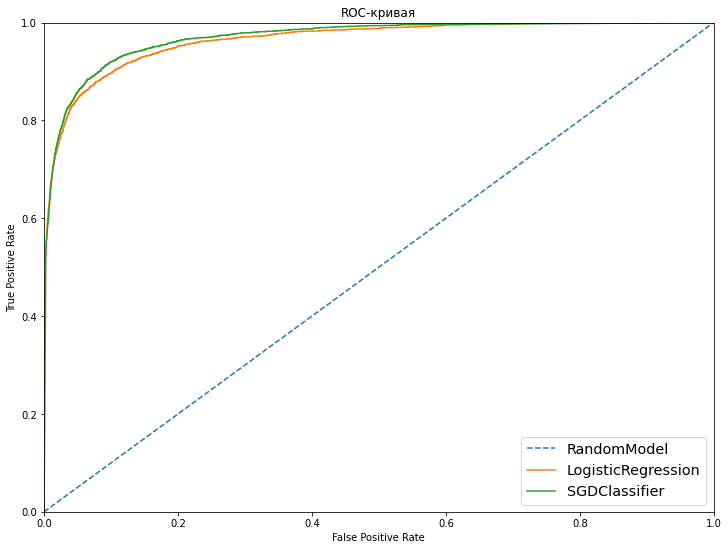

In [24]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


classificator = LogisticRegression()
classificator.set_params(**LR_best_params)
classificator.fit(features_train, target_train)
probabilities_test = classificator.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = classificator.predict(features_test)
plt.plot(fpr, tpr, label='LogisticRegression')
print('Метрики LogisticRegression')
print('ROC AUC:', roc_auc_score(target_test, probabilities_one_test))
print('F1:', f1_score(target_test, predict_test))
print('Precision:', precision_score(target_test, predict_test))
print('Recall:', recall_score(target_test, predict_test))
print('Accuracy:', accuracy_score(target_test, predict_test))
print()

classificator = SGDClassifier()
classificator.set_params(**SGDC_best_params)
classificator.fit(features_train, target_train)
probabilities_test = classificator.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = classificator.predict(features_test)
plt.plot(fpr, tpr, label='SGDClassifier')
print('Метрики SGDClassifier')
print('ROC AUC:', roc_auc_score(target_test, probabilities_one_test))
print('F1:', f1_score(target_test, predict_test))
print('Precision:', precision_score(target_test, predict_test))
print('Recall:', recall_score(target_test, predict_test))
print('Accuracy:', accuracy_score(target_test, predict_test))
print()

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

### Итоговый вывод

В ходе работы над проектом было сделано:

- подготовленны данные обучения на моделях;
- выбран способ баланса классов и поделены данные на обучающую, валидационную и тестовою выборку;
- обучены модели и выбраны лучшие из них на валидационной выборке;
- показаны параметры качества моделей.

Исходные данные обладают большим количеством признаков. Созданных столбцов больше, чем записей данных. Так как TF-IDF превращают текст в численные значения, лучшими моделями стали LogisticRegression и SGDClassifier.

На тестовой выбоке по метрике F1 лучше всего себя показал LogisticRegression всего на 0.07. Данная модель обладает больними показателями Precision и Accuracy. Это говорит нам, что токсичные комментарии находятся лучше.

SGDClassifier показал себя лучше в ROC AUC и Recall метриках. Модель способна обработать больше записей.